# MA934  Numerical Methods - Workbook 2

In [1]:
using Plots
pyplot()
include("KVPair.jl")
include("LList.jl")
include("FTree.jl")

buildFTree (generic function with 1 method)

## Question 1: Linear search using a linked list

The file KVPair.jl defines a simple data structure to represent an (Int64, Float64) key-value pair. 

The file LList.jl defines a linked list that stores a KVPair at each node. Many languages have a keyword NULL. A pointer to any object can take the value NULL to indicate that it doesn't point to anything. NULL is often used to denote the end of a list, the leaves of a tree etc. Julia does not support NULL pointers. This causes a difficulty in implementing recursive data structures. Instead Julia provides a parametric data type Nullable{T} to represent missing values. It is possible to use Nullable types to define recursive data structures although some of the resulting definitions are a bit clumsy. I'm not sure that this is the canonical way to implement structural recursion in Julia. 

The following points are important:

* if a variable has type Nullable{T} then it can either contain a value of type T or nothing (ie a missing value). 
* the function isnull(x) checks whether a nullable type x has a value or not. 
* the function get(x) returns the actual value (of type T) contained in a nullable type x.

Much more information can be found at https://docs.julialang.org/en/stable/manual/types/

The function 

> buildLList(dataArray::Array{KVPair, 1})

takes an array of KVPair objects as input and returns an LList containing these KVPairs. This is illustrated in the code below.

1. Write a recursive function that traverses the list and prints out the key-value pairs stored in it. Check that your function works.
 

In [2]:
n = 10
x = rand(1, n)
values = Array{KVPair}(n)
for i in 1:n
    values[i] = KVPair(i,x[i])
end
values


10-element Array{KVPair,1}:
 KVPair(1, 0.728496) 
 KVPair(2, 0.712227) 
 KVPair(3, 0.816131) 
 KVPair(4, 0.798479) 
 KVPair(5, 0.387267) 
 KVPair(6, 0.646962) 
 KVPair(7, 0.224677) 
 KVPair(8, 0.200653) 
 KVPair(9, 0.229901) 
 KVPair(10, 0.135006)

In [3]:
L = Nullable{LList}()
List = buildLList(values)

Nullable{LList}(LList(KVPair(1, 0.728496), LList(KVPair(2, 0.712227), LList(KVPair(3, 0.816131), LList(KVPair(4, 0.798479), LList(KVPair(5, 0.387267), LList(KVPair(6, 0.646962), LList(KVPair(7, 0.224677), LList(KVPair(8, 0.200653), LList(KVPair(9, 0.229901), LList(KVPair(10, 0.135006), #NULL)))))))))))

In [4]:
function recursion(list::Nullable{LList})
    A = get(list)
    @show A.data.key
    
    if( !isnull(A.next) )
        return recursion(A.next)
    else
        return false
    end
end

recursion(List)

A.data.key = 1
A.data.key = 2
A.data.key = 3
A.data.key = 4
A.data.key = 5
A.data.key = 6
A.data.key = 7
A.data.key = 8
A.data.key = 9
A.data.key = 10


false

<font color=blue>
You should use the print function instead of the @show macro. Also, why didn't you print the corresponding values too?
It is not clear why a print function should return a boolean value - most people would just return void.
</font>

$2.$ Write a function search(list::Nullable{LList}, k::Int64) that searches an LList for the key k and returns the corresponding KVPair if it is present and a Nullable{KVPair} otherwise. 

In [5]:
function search(llist::Nullable{LList}, k::Int64)
    
    if isnull(llist)
        return
    else
        if get(llist).data.key == k
            return get(llist).data
        else
            return search(get(llist).next, k)
        end
    end
end

search(List, 7)

KVPair(7, 0.22467726361824103)

<font color=blue>
This looks good.
</font>

$3.$ Use Julia's @timed macro to measure how the typical computational cost of your search() function grows with the length of the list. 

In [6]:
A=@timed(search(List,7))
A[2]

1.2718e-5

In [7]:
arr1 = []

for i = 1:n
    #Q = rand(1,n)
    tim1 = @timed(search(List,n))[2]
    push!(arr1,tim1)
end
arr1

10-element Array{Any,1}:
 1.808e-6
 3.3e-7  
 2.15e-7 
 1.67e-7 
 1.63e-7 
 1.65e-7 
 1.63e-7 
 1.62e-7 
 1.62e-7 
 1.63e-7 

<font color=blue>
This is not correct - you are not varying the length of the list. It seems you are trying to measure the time required
to find the $n^{th}$ element of a list of fixed length? Unclear what the plot means - it has no labels or axes.
</font>


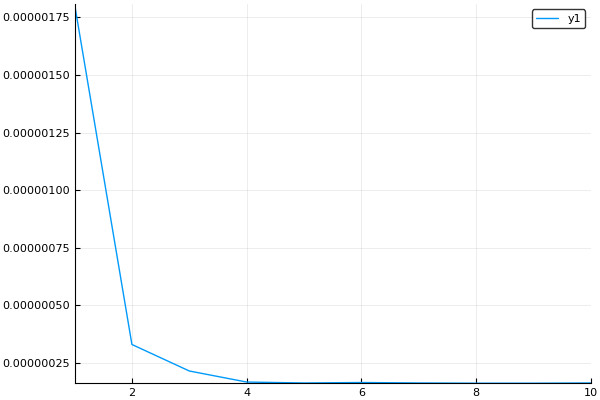

In [8]:
n = 1:10
plot(n, arr1)

<font color=blue>
8/15
</font>

## Question 2: Interval membership

The problem of interval membership is the following: given a set of contiguous intervals, 

$\left\{[x_0, x_1), [x_1, x_2), \ldots, [x_{n-2}, x_{n-1}), [x_{n-1}, x_n)\right\}$

spanning the interval $[x_1, x_n)$ and given a random number $x \in [x_1, x_n)$, determine the interval in which $x$ lies. The standard numerical algorithm for stochastic simulation of continuous-time Markov processes (eg birth-death process, contact process, SIR model etc) requires solving an interval membership problem at each time step. It is therefore important to be able to solve it efficiently. Note, we cannot assume that all intervals are the same length.

We can solve the interval membership problem with $n$ interval by a variant of linear search in $O(n)$ time. We will demonstrate below that it can be solved in $O(\log\, n)$ time using a variant of a data structure known as a Fenwick tree.

**1)** Use Julia's random number generator to generate $n$ random interval lengths, $y_1, y_2, \ldots, y_n$ between 0 and 1 as shown: 

In [9]:
# Set number of intervals
n=10
# Seed for random number generator. 
# You should choose your own seed so that everyone does not end up with the same random sequences
seed = 123 
# Initialise the random number generator
rng = MersenneTwister(seed)
# Generate a sample of n uniform random numbers in the interval [0,1]
X = rand(rng, n)


10-element Array{Float64,1}:
 0.768448 
 0.940515 
 0.673959 
 0.395453 
 0.313244 
 0.662555 
 0.586022 
 0.0521332
 0.26864  
 0.108871 

The corresponding interval membership problem is constructed from the partial sums:
$$x_i = \sum_{j=1}^i y_j, \ \ \ \ \ i=1,2,\ldots n.$$ 
Using the objects defined in KVPair.jl and LList.jl, create an array of key-value pairs, $(i, x_i)$, associating each interval with the corresponding partial sum and store this array in a linked list. Print the list for a small value of $n$to verify that it works.

**2)** Modify the search function you wrote above to write a recursive function

$$\text{intervalmembership(list::Nullable{LList}, x::Float64)}$$

that takes the LList containing the list of partial sums and a random Float64 in the range $[0, x_n]$ as inputs and returns the KVPair corresponding to the interval in which $x$ lies. Verify that it works for small values of $n$ and use Julia's @timed macro to measure how the typical computational cost grows with $n$. 

**3)** The file FTree.jl defines a data structure implementing a variant of a Fenwick tree that can solve the interval membership problem as described in the lectures/notes. The function 

$$\text{buildFTree(T::Nullable{FTree}, dataArray::Array{KVPair, 1})}$$

takes the array of KVPairs containing the interval lengths as input, recursively constructs the tree and returns the FTree containing the correct key-value pairs (note a key of -1 is assigned to all non-leaf nodes).

In [10]:
val = Array{KVPair}(n)
function part_sum(x)
    ssum = 0.0
    val = Array{KVPair}(n)

    for i in 1:length(x)
        ssum += x[i]
        val[i] = KVPair(i,ssum)
    end
    return val
end
val=part_sum(X)

10-element Array{KVPair,1}:
 KVPair(1, 0.768448)
 KVPair(2, 1.70896) 
 KVPair(3, 2.38292) 
 KVPair(4, 2.77837) 
 KVPair(5, 3.09162) 
 KVPair(6, 3.75417) 
 KVPair(7, 4.3402)  
 KVPair(8, 4.39233) 
 KVPair(9, 4.66097) 
 KVPair(10, 4.76984)

In [11]:
lists = buildLList(val)

Nullable{LList}(LList(KVPair(1, 0.768448), LList(KVPair(2, 1.70896), LList(KVPair(3, 2.38292), LList(KVPair(4, 2.77837), LList(KVPair(5, 3.09162), LList(KVPair(6, 3.75417), LList(KVPair(7, 4.3402), LList(KVPair(8, 4.39233), LList(KVPair(9, 4.66097), LList(KVPair(10, 4.76984), #NULL)))))))))))

In [12]:
function intervalmembership(list::Nullable{LList}, x::Float64)


    if x < get(list).data.value
        return get(list).data
    else 
        return intervalmembership(get(list).next, x)
    end
end

intervalmembership(lists, 2.3)

KVPair(3, 2.382921370479824)

<font color=blue>
This is correct.
</font>

In [13]:
n=5
arr1_1 = []

for i = 1:n
    Xxx = rand(1,n)
    time1 = @timed(intervalmembership(lists,Xxx[i]))[2]
    push!(arr1_1,time1)
end
arr1_1

5-element Array{Any,1}:
 5.8612e-5
 3.25e-7  
 1.44e-7  
 1.26e-7  
 1.27e-7  

In [14]:
arr1_2 = []

for i = 1:n
    push!(arr1_2, i)
end

arr1_2

5-element Array{Any,1}:
 1
 2
 3
 4
 5


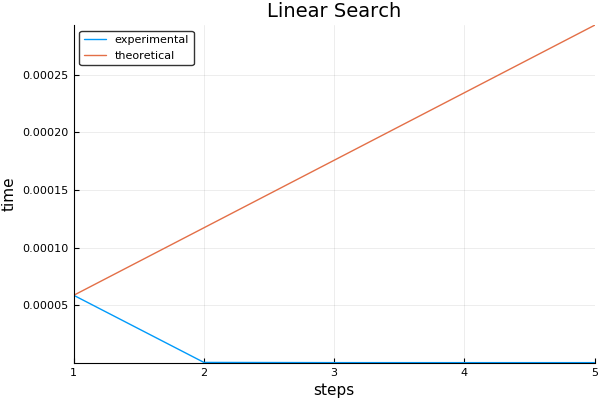

In [15]:
n1 = 1:5
plot(n1,arr1_1, label="experimental")
plot!(n1,arr1_2.*arr1_1[1], label="theoretical")
xlabel!("steps")
ylabel!("time")
title!("Linear Search")

<font color=blue>
You seem to have made the same error similar to the above. Your list of partial sums is of fixed length. Also, you 
are running your interval membership function using random numbers between 0 and 1 rather than between 0 and the total interval length (you need to re-read what the question is asking you to do):
</font>

In [17]:
Xxx=rand(1,n)

1×5 Array{Float64,2}:
 0.352111  0.875338  0.596717  0.220307  0.581439

Write a recursive function

$$\text{intervalmembership(FT::Nullable{FTree}, x::Float64)}$$

that takes the FTree containing the list of partial sums and a random Float64 in the range $[0, x_n]$ as 
inputs and returns the KVPair corresponding to the interval in which $x$ lies. Verify that it works for small values of $n$ and use Julia's @timed macro to compare how the typical computational compares to the above linear search version. Note it can sometimes be difficult to directly measure $O(\log\, n)$ growth in computation time since the problem size needs to become very large to register appreciable run times.

In [18]:
n=5
seed = 123
X = rand(1, n)
sums = 0.0

# Now calculate the array of partial sums
values = Array{KVPair}(n)
for i in 1:n
    sums += X[i]
    values[i] = KVPair(i,X[i])
end
T = Nullable{FTree}(FTree(KVPair(0,0.0)))
T = buildFTree(T, values)
#@show get(T).data.value
#@show get(get(T).right).data.value


Nullable{FTree}(FTree(KVPair(-1, 2.39254), FTree(KVPair(-1, 0.713085), FTree(KVPair(1, 0.182989), #NULL, #NULL), FTree(KVPair(2, 0.530096), #NULL, #NULL)), FTree(KVPair(-1, 1.67946), FTree(KVPair(3, 0.156812), #NULL, #NULL), FTree(KVPair(-1, 1.52264), FTree(KVPair(4, 0.695331), #NULL, #NULL), FTree(KVPair(5, 0.827312), #NULL, #NULL)))))

In [19]:
function int_mem_tree(FT::Nullable{FTree}, x::Float64)

    node = get(FT)
    
    if isnull(node.left) && isnull(node.right)
        return node.data
    else
        if x <= get(node.left).data.value
            return int_mem_tree(node.left, x)
        else
            return int_mem_tree(node.right, x-get(node.left).data.value)
        end
    end
    
end

int_mem_tree(T, 0.5)

KVPair(2, 0.5300961092218328)

<font color=blue>
This looks correct but you should test it on more values to be sure:
</font>

In [22]:
[int_mem_tree(T, 0.25), int_mem_tree(T, 1.5), int_mem_tree(T, 2.5)]

3-element Array{KVPair,1}:
 KVPair(2, 0.530096)
 KVPair(4, 0.695331)
 KVPair(5, 0.827312)

In [23]:
arr2_1 = []

for i = 1:n
    W = rand(1,n)
    time2 = @timed(int_mem_tree(T, W[i]))[2]
    push!(arr2_1,time2)
end
arr2_1

5-element Array{Any,1}:
 3.1787e-5
 5.41e-7  
 2.33e-7  
 1.98e-7  
 2.15e-7  

In [24]:
arr2_2 = []

for i = 1:n
    push!(arr2_2, log(i))
end

arr2_2

5-element Array{Any,1}:
 0.0     
 0.693147
 1.09861 
 1.38629 
 1.60944 


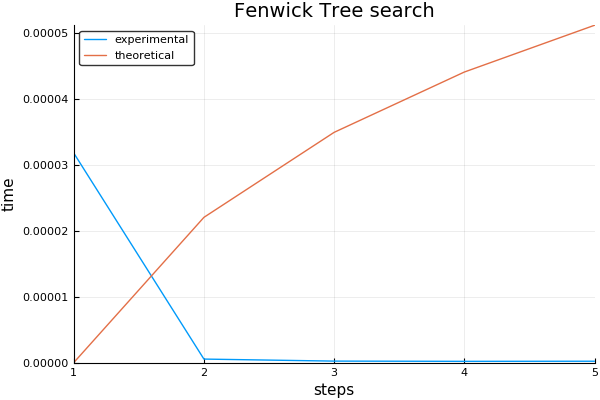

In [25]:
n2 = 1:5
plot(n2,arr2_1, label="experimental")
plot!(n2,arr2_2.*aint_mem_tree(T, 2.5)rr2_1[1], label="theoretical")
xlabel!("steps")
ylabel!("time")
title!("Fenwick Tree search")

<font color=blue>
Same problems as above.
</font>

<font color=blue>
8/15
</font>

## Question 3: Gillespie algorithm for heterogeneous diffusion

The Gillespie algorithm is a dynamic Monte Carlo algorithm that generates statistically correct realisations of a continous time Markov process. See https://en.wikipedia.org/wiki/Gillespie_algorithm It is used heavily in stochastic simulation of chemical and biological reaction networks and population dynamics. In this question we use it to simulate one-dimensional diffusion of heterogeneous particles whose diffusion constants are independently drawn from an exponential distribution.

The basic idea of the algorithm is as follows
1. Create a list $\left\{(i, r_i), i=1,\ldots M\right\}$,  of all possible transitions (events), $i$, that can occur in the system and the corresponding transition rates, $r_i$.
2. Calculate the total rate
$$R = \sum_{i=1}^M r_i$$
and divide the interval $[0, R]$ into $M$ intervals whose lengths are given by the $r_i$.
3. Generate a uniform random number in the range $[0,R]$ and determine which interval it falls in. 
4. Perform the corresponding transition and update the time variable by an amount $\Delta t = 1/R$.
5. Repeat until the desired simulation time is reached.

To be concrete, suppose with have $N$ particles on the interval $[-L, L]$ initially located at $x=0$. Each particle can hop a distance $\Delta x$ to the left or to the right with equal probability. The rate of hopping is initially considered to be the same for all particles:

$$ r_i = \frac{D}{2}\,\frac{1}{(\Delta x)^2} $$

This choice ensures that in the continous limit ($\Delta x \to 0$, $N\to \infty$), the density of particles $c(x,t)$ on the line will satisfy the usual diffusion equation with diffusion coefficient $D$ (recall MA933):

$$ \frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial x^2}$$

with initial condition $c(x,0) = \delta(x)$.

The steps of the algorithm then correspond to the following:
1. There are $M= 2 N$ possible transitions at each step: each of $N$ particles can hop a distance $\Delta x$ either left or right with the above rates. We index them as follows: events k=1:N correspond to particle k hopping to the right, events k=N+1:2N correspond to particle k-N hopping to the left.
2. The total rate is 
$$ R = \frac{D N}{(\Delta x)^2}.$$
3. Generate a uniform random number in the range $[0,R]$ and determine the index $k$ of particle to move and the direction.
4. Update the position of particle $k$ accordingly.
5. Repeat.

The following piece of code implements the Gillespie algorithm for N=100, L=10, $\Delta x = 0.1$ and $D=1$, converts the particle positions to particle density and compares to the solution of the diffusion equation on an unbounded domain at t=1 (we assume that L=10 is far enough from zero to be considered unbounded):

$$c(x, t) = \frac{1}{\sqrt{2 \pi D t}}\, \exp [-\frac{1}{2}\frac{x^2}{D t} ]$$


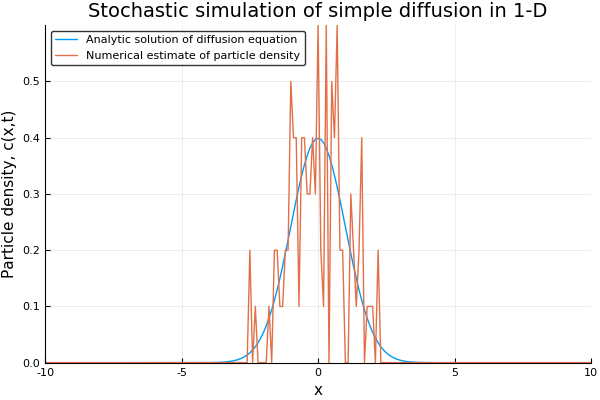

In [29]:
L=10.0
N=100
Nx = 201
dx = 2.0*L/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y =zeros(Int64,N)
D = 1.0
t=0.0


r = (D/2.0)/(dx*dx) 
totalRate = 2.0*N*r

dt = 1.0/totalRate
T=1.0

# This is the main loop
while t < T
    # Pick an event
    k = rand(1:2*N)
    if k<=N
        hop = 1
        particleId = k
    else
        hop = -1
        particleId=k-N
    end
    Y[particleId]+=hop
    t+=dt
end

# Calculate the estimated density of particles
P =zeros(Float64,length(X))
for i in 1:length(Y)
    P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end

# Calculate the theoretical density and compare
function normal(x, D, t)
    return (1.0/sqrt(2.0*pi*D*t))*exp(-x*x/(2*D*t))
end
P1 = normal.(X, D, T)
plot(X, P1, label="Analytic solution of diffusion equation")
plot!(X, P, label="Numerical estimate of particle density")
xlabel!("x")
ylabel!("Particle density, c(x,t)")
title!("Stochastic simulation of simple diffusion in 1-D")

**1)** The code above makes critical use of the fact that all intervals have the same width in order to decide which particle to move at each step. Suppose now that instead of being equal to $D$ for each particle, the diffusion coefficients are drawn from an exponential distribution with mean $D$:

$$ P(x) = \frac{1}{D} \exp\left(-\frac{x}{D}\right). $$

Modify the code to account for this, using your code from Q2 above to solve the interval membership problem using linear search. You will need to use Julia's randexp() function to generate values for the diffusion coefficients. What is the largest value of $N$ you can simulate in a "reasonable" time?




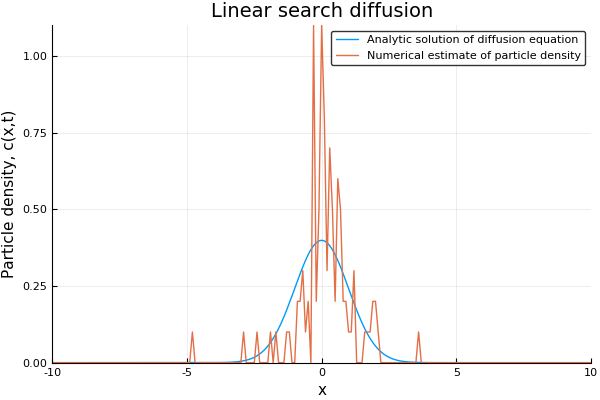

In [30]:
L=10.0
N=100
Nx = 201
dx = 2.0*L/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y =zeros(Int64,N)
D = 1.0
t=0.0

D_exp = randexp(N)
D_exp = [D_exp;D_exp] #to make it symmetrical
rate_exp = (D_exp./2.0)./(dx*dx)
totalRate = sum(rate_exp) 

dt = 1.0/totalRate
T=1.0


x = zeros(2*N)
values = Array{KVPair}(2*N)
for i=1:2*N
    for j=1:i
        x[i]=x[i]+rate_exp[j]
    end
    values[i]=KVPair(i,x[i])
end
ListS = Nullable{LList}()
ListS = buildLList(values)


# This is the main loop
while t < T
    # Pick an event
    findRate = rand()*totalRate
    #node = intervalmembership(ListS,findRate)
    k = intervalmembership(ListS,findRate).key
    if k<=N
        hop = 1
        particleId = k
    else
        hop = -1
        particleId=k-N
    end
    Y[particleId]+=hop
    t+=dt
end

# Calculate the estimated density of particles
P =zeros(Float64,length(X))
for i in 1:length(Y)
    P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end

# Calculate the theoretical density and compare
function normal(x, D, t)
    return (1.0/sqrt(2.0*pi*D*t))*exp(-x*x/(2*D*t))
end

P1 = normal.(X, D, T)
plot(X, P1, label="Analytic solution of diffusion equation")
plot!(X, P, label="Numerical estimate of particle density")
xlabel!("x")
ylabel!("Particle density, c(x,t)")
title!("Linear search diffusion")


**2)** Try again using your Fenwick tree from Q2 to solve the interval membership problem and compare. What is the largest value of $N$ you can simulate now?

In [31]:
L=10.0
N=100
Nx = 201
dx = 2.0*L/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y1 =zeros(Int64,N)
D = 1.0
t=0.0

dt = 1.0/totalRate
T=1.0


Tr = Nullable{FTree}(FTree(KVPair(0,0.0)))
Tr = buildFTree(Tr, values)


# This is the main loop
while t < T
    findRate = rand()*totalRate
    k = int_mem_tree(Tr,findRate).key
    if k<=N
        hop = 1
        particleId = k
    else
        hop = -1
        particleId=k-N
    end
    Y1[particleId]+=hop
    t+=dt
end


# Calculate the estimated density of particles
P2 =zeros(201)
for i in 1:length(Y)
    P2[Y1[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end


# Calculate the theoretical density and compare
function normal(x, D, t)
    return (1.0/sqrt(2.0*pi*D*t))*exp(-x*x/(2*D*t))
end

P1 = normal.(X, D, T)
plot(X, P1, label="Analytic solution of diffusion equation")
plot!(X, P2, label="Numerical estimate of particle density")
xlabel!("x")
ylabel!("Particle density, c(x,t)")
title!("Stochastic simulation of simple diffusion in 1-D")

LoadError: [91mBoundsError: attempt to access 201-element Array{Float64,1} at index [246][39m

<font color=blue>
This code doesn't run for me. Not sure what you have done wrong.
</font>

**3)** Show analytically that the solution of the heterogenous diffusion problem is

$$ c(x,t) = \frac{\exp \left(-\sqrt{\frac{2}{D\,t}}\, |x| \right)}{\sqrt{2\, D\, t}}$$

You will probably need the integral formula (Formula 3.325 of Gradshteyn and Rizhik, 7th Ed.)

$$ \int_0^\infty \exp\left(-a\,x^2 - \frac{b}{x^2} \right)\, dx =  \frac{1}{2}\,\sqrt{\frac{\pi}{a}}\,\exp\left(-2 \sqrt{a\,b} \right).$$
Use this formula to validate your numerical results.


$$c(x,t)=\frac{1}{\sqrt{2\pi Dt}}\exp(-{\frac{x^2}{2Dt}}) $$

$$<c(x,t)>  = \int_0^\infty dy \frac{1}{D}\exp(\frac{-y}{D})\frac{1}{\sqrt{2\pi yt}}\exp(\frac{-x^2}{2yt}) = \frac{1}{D\sqrt{2\pi t}} \int_0^\infty dy \frac{1}{y^{1/2}} \exp(\frac{-y}{D}) \exp(\frac{-x^2}{2yt}) = 
\frac{1}{D\sqrt{2\pi t}} \int_0^\infty dy \frac{1}{y^{1/2}} \exp(-\frac{y}{D}-\frac{x^2}{2yt}) $$


By using the substitution $u=y^{1/2}$ and $du = \frac{1}{2y^{1/2}}dy $


$$ <c(x,t)> = \frac{2}{D\sqrt{2\pi t}} \int_0^\infty \exp(-\frac{u^2}{D} - \frac{x^2}{2t}\frac{1}{u^2}) du = \frac{2}{D \sqrt{2\pi t}}\frac{\sqrt{\pi D}}{2} \exp(-2\sqrt{\frac{x^2}{2Dt}}) = \frac{1}{\sqrt{2Dt}} \exp(-\sqrt{\frac{2}{Dt}} |x|) $$

$$ <c(x,t)> = \frac{1}{\sqrt{2Dt}} \exp(-\sqrt{\frac{2}{Dt}} |x|) $$

<font color=blue>
This is correct.
</font>

<font color=blue>
10/15
</font>